In [17]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.tsa.ar_model import AutoReg
import time
import warnings
from sklearn.decomposition import PCA
import pandas as pd
from matplotlib import ticker
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [3]:
warnings.filterwarnings("ignore") # para ignorar os warnings de funcoes
plt.rcParams['figure.figsize'] = [16, 8] # para aumentar o tamanho das figuras
plt.rcParams.update({'font.size': 16}) # para aumentar a fonte das palavras nos graficos

## Lendo os dados
Código fornecido pelo Prof Helon Ayala

In [4]:
fname = os.getcwd() + '\\..\\data\\data3SS2009.mat'

mat_contents = sio.loadmat(fname)

dataset = mat_contents['dataset']

N, Chno, Nc = dataset.shape
# N: number of samples
# Chno: number of channels
# Nc: number of cases

y = mat_contents['labels'].reshape(Nc)

# y

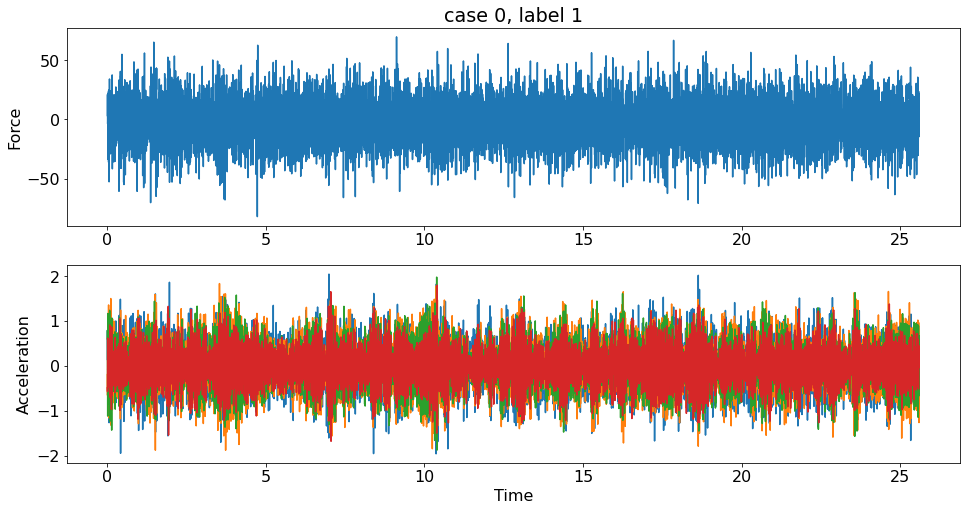

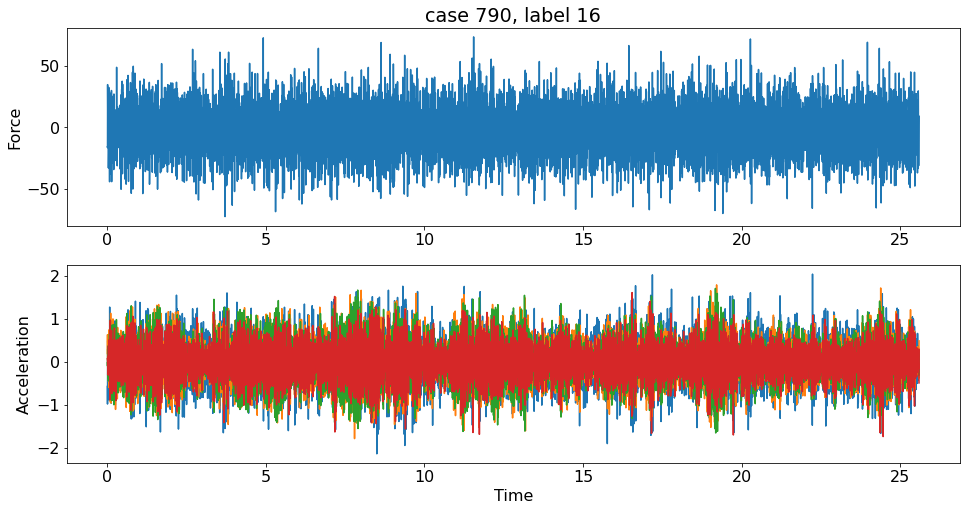

In [5]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

Ts = 3.125 * 1e-3 # sampling time
time_vec = (np.linspace(1,N,N) - 1) * Ts

for case in np.array([0,790]):
    plt.figure(case)
    plt.subplot(211)
    plt.title('case %d, label %d' % (case, y[case]))
    plt.plot(time_vec,Ch1[:,case])
    plt.ylabel('Force')
    plt.subplot(212)
    plt.plot(time_vec,Ch2[:,case],time_vec,Ch3[:,case],time_vec,Ch4[:,case],time_vec,Ch5[:,case])
    plt.xlabel('Time')
    plt.ylabel('Acceleration')
    plt.show()

## Ajustando modelos AR-X

In [6]:
t_ini = time.time()

lag = 29 # escolhido o 29 para que a matriz X1 tenha o formato 850x120
canais = [Ch2, Ch3, Ch4, Ch5]

X1 = []

for amostra in range(850): # loop sobre as amostras medidas (series temporais)
    
    parametros = []
    
    for canal in canais: # loop sobre os 4 canais de interesse
        
        ajuste = AutoReg(canal[:,amostra],lags=lag).fit()
        parametros.append(ajuste.params) # montando cada uma das 850 linhas da matriz
        
    X1.append(np.hstack(parametros)) # inserindo a linha na matriz

X1 = np.array(X1)

t_final = time.time()

print('Processo de ajuste dos modelos AR demorou {:.2f} segundos.'.format((t_final - t_ini)))

print('Formato da matriz X1: {}'.format(X1.shape))

Processo de ajuste dos modelos AR demorou 35.60 segundos.
Formato da matriz X1: (850, 120)


## Aplicando o PCA

Text(0, 0.5, 'Percentual da Variância Explicada (%)')

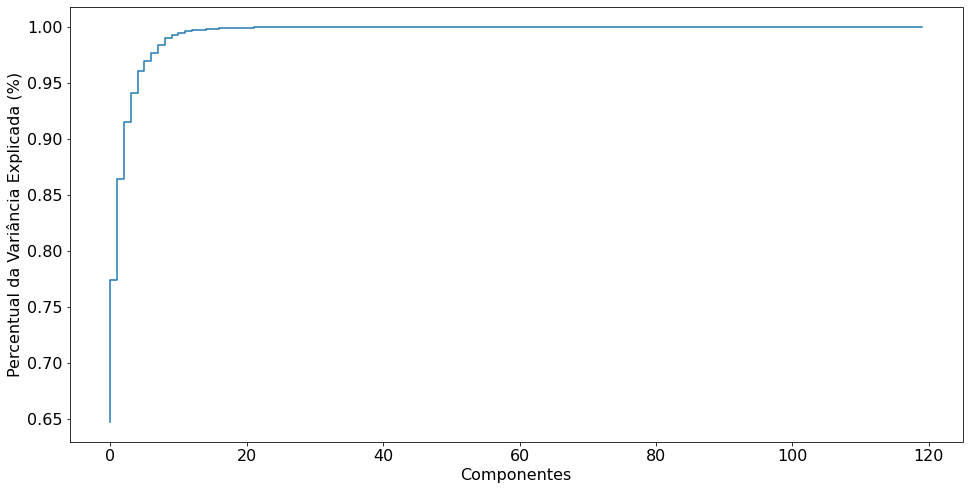

In [7]:
# Grafico que informa quanto da variancia e explicada utilizando X componentes

pca_full = PCA().fit(X1)

var_exp = pca_full.explained_variance_ratio_
var_cumu = np.cumsum(var_exp)

plt.step(range(0,len(var_cumu)),var_cumu)

plt.xlabel('Componentes')
plt.ylabel('Percentual da Variância Explicada (%)')


O gráfico acima mostra que grande parte das informações presente nos dados medidos pode ser bem representada com um número muito menor de componentes. Por exemplo, a curva se aproxima bastante de 100% a partir de 25 componentes.

Porcentagem da variancia explicada por cada componente:
Componente 1: 64.70%
Componente 2: 12.65%
Componente 3: 9.02%
Componente 4: 5.11%
Componente 5: 2.62%
Componente 6: 1.95%
Componente 7: 0.86%
Componente 8: 0.75%
Componente 9: 0.73%


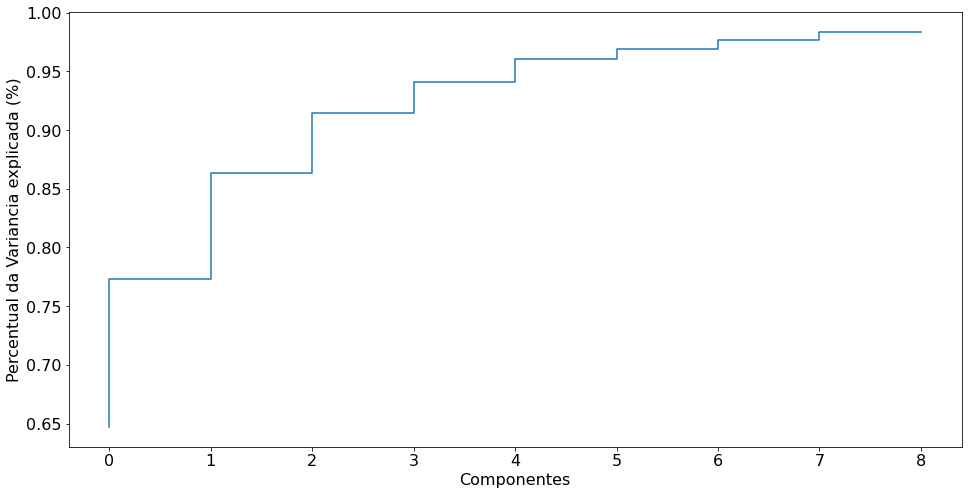

In [8]:
meta_variancia_exp = 0.98

pca = PCA(n_components = meta_variancia_exp, svd_solver = 'full').fit(X1)

var_exp = pca.explained_variance_ratio_
var_cumu = np.cumsum(var_exp)

plt.step(range(0,len(var_cumu)),var_cumu)

plt.xlabel('Componentes')
plt.ylabel('Percentual da Variancia explicada (%)')

print('Porcentagem da variancia explicada por cada componente:')
for i in range(len(var_exp)):
    print('Componente {}: {:.2f}%'.format(i+1, var_exp[i]*100))

X2 = pca.transform(X1)

Para garantir que 98% da variância consiga ser bem representada, basta utilizar 9 componentes, em que a capacidade que cada um tem para representar a variância nos dados está apresentada na célula acima.

## Normalizando as features

In [9]:
# def normaliza(X):
    
#     x_min = np.min(X)
#     x_max = np.max(X)
    
#     X_scaled = (X - x_min)/(x_max - x_min)
    
#     return X_scaled

In [10]:
# X1_scaled = normaliza(X1)
# print('min = {}'.format(np.min(X1_scaled)))
# print('max = {}'.format(np.max(X1_scaled)))

In [11]:
# X2_scaled = normaliza(X2)
# print('min = {}'.format(np.min(X2_scaled)))
# print('max = {}'.format(np.max(X2_scaled)))

Foi feita a tentativa de normalizar via a função "normaliza(X)" implementada acima. Porém, essa normalização simples não foi suficiente para melhorar o ajuste dos modelos no final do exercício. Por esse motivo, optou-se utilizar a função MinMaxScaler do pacote Sklearn.

De qualquer forma, é interessante notar como a forma em que a normalização é feita tem impacto direto no desempenho do modelo ajustado a partir dos dados normalizados.

In [12]:
scaler = MinMaxScaler(feature_range=(-1,1))

X1_scaled = scaler.fit(X1).transform(X1)

X2_scaled = scaler.fit(X2).transform(X2)

## Visualizando e Comparando X1 e X2

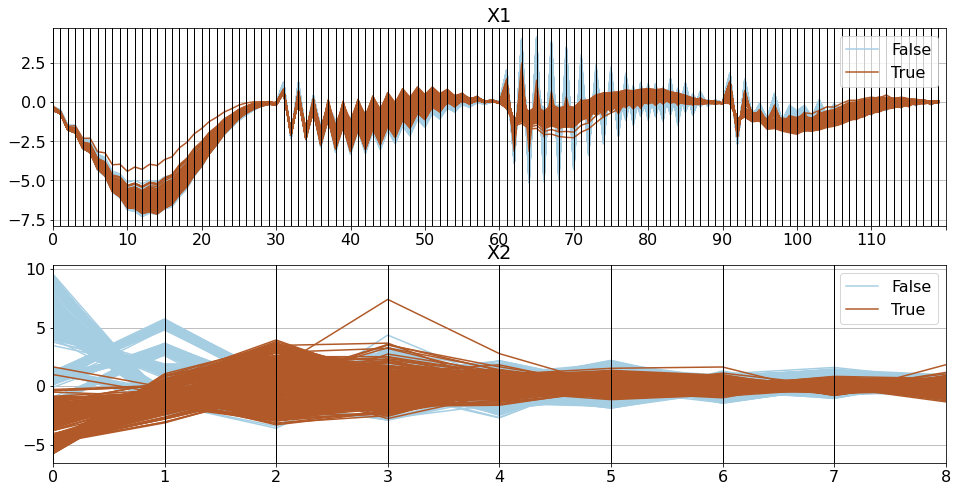

In [13]:
indDam = y > 9

dfX1 = pd.concat([pd.DataFrame(X1),pd.DataFrame({'target':indDam})],axis=1)
dfX2 = pd.concat([pd.DataFrame(X2),pd.DataFrame({'target':indDam})],axis=1)

fig = plt.figure()
ax1 = fig.add_subplot(211)
pd.plotting.parallel_coordinates(dfX1,'target',colormap=plt.get_cmap('Paired'))
ax1.title.set_text('X1')
plt.xticks(np.arange(0, 121, 10))


ax2 = fig.add_subplot(212)
pd.plotting.parallel_coordinates(dfX2,'target',colormap=plt.get_cmap('Paired'))
ax2.title.set_text('X2')

## Visualizando X1 e X2 normalizados

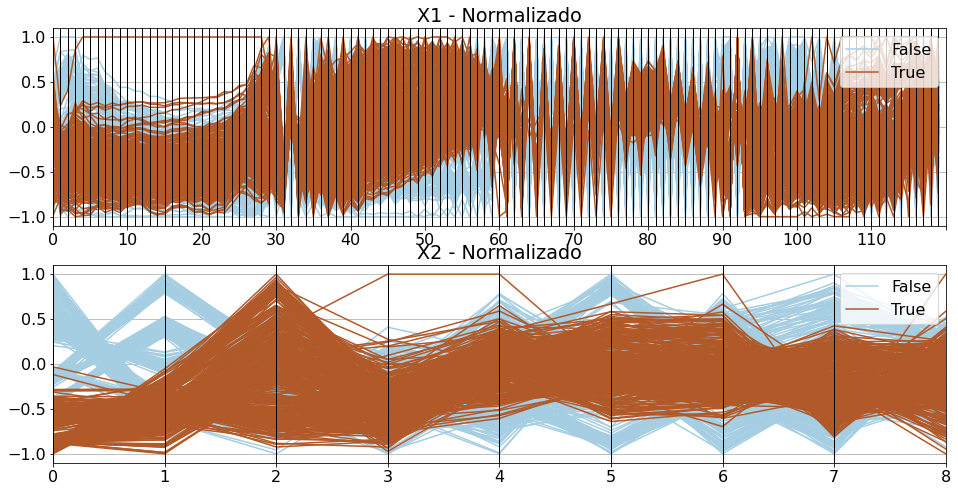

In [14]:
indDam = y > 9

dfX1_scaled = pd.concat([pd.DataFrame(X1_scaled),pd.DataFrame({'target':indDam})],axis=1)
dfX2_scaled = pd.concat([pd.DataFrame(X2_scaled),pd.DataFrame({'target':indDam})],axis=1)

fig = plt.figure()
ax1 = fig.add_subplot(211)
pd.plotting.parallel_coordinates(dfX1_scaled,'target',colormap=plt.get_cmap('Paired'))
ax1.title.set_text('X1 - Normalizado')
plt.xticks(np.arange(0, 121, 10))


ax2 = fig.add_subplot(212)
pd.plotting.parallel_coordinates(dfX2_scaled,'target',colormap=plt.get_cmap('Paired'))
ax2.title.set_text('X2 - Normalizado')

## Ajustando modelos lineares Softmax

In [15]:
logreg_X1 = LogisticRegression(multi_class='multinomial',solver = 'lbfgs', max_iter=1000).fit(X1, y)
score_X1 = logreg_X1.score(X1, y)
print('A acurácia média do modelo ajustado para X1 é de {:.4f};'.format(score_X1))

logreg_X2 = LogisticRegression(multi_class='multinomial',solver = 'lbfgs', max_iter=1000).fit(X2, y)
score_X2 = logreg_X2.score(X2, y)
print('A acurácia média do modelo ajustado para X2 é de {:.4f};'.format(score_X2))

logreg_X1_scaled = LogisticRegression(multi_class='multinomial',solver = 'lbfgs', max_iter=1000).fit(X1_scaled, y)
score_X1_scaled = logreg_X1_scaled.score(X1_scaled, y)
print('A acurácia média do modelo ajustado para X1 normalizado é de {:.4f};'.format(score_X1_scaled))

logreg_X2_scaled = LogisticRegression(multi_class='multinomial',solver = 'lbfgs', max_iter=1000).fit(X2_scaled, y)
score_X2_scaled = logreg_X2_scaled.score(X2_scaled, y)
print('A acurácia média do modelo ajustado para X2 normalizado é de {:.4f};'.format(score_X2_scaled))

A acurácia média do modelo ajustado para X1 é de 0.9953;
A acurácia média do modelo ajustado para X2 é de 0.9706;
A acurácia média do modelo ajustado para X1 normalizado é de 0.9988;
A acurácia média do modelo ajustado para X2 normalizado é de 0.9612;


## Resumo ajuste Softmax X2

A acurácia média do modelo ajustado para X2 é de 0.9706;


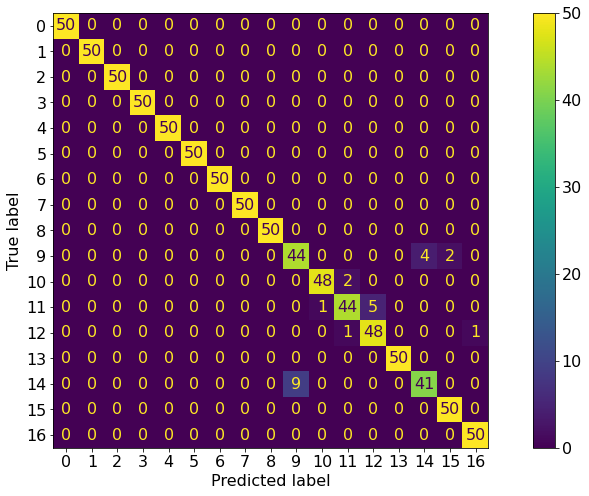

In [21]:
logreg_X2 = LogisticRegression(multi_class='multinomial',solver = 'lbfgs', max_iter=1000).fit(X2, y)
score_X2 = logreg_X2.score(X2, y)
print('A acurácia média do modelo ajustado para X2 é de {:.4f};'.format(score_X2))

cm = confusion_matrix(y, logreg_X2.predict(X2))
ConfusionMatrixDisplay(cm).plot()

## Testando modelos SVM para X2

Serão testados modelos SVM variando os parâmetros C e kernel. 

Para o valor C, serão avaliados 3 valores, sendo um valor o default, um valor menor e um valor maior (0.5, 1.0 e 2.0);

Para o kernel, serão avaliados 3 tipos: linear, fbr e poly;

Para o kernel polinomial, serão testados 3 valores, sendo um o default, um valor menor e um valor maior (2, 3 e 4).

########### Testando kernel linear ###########
	C = 0.5 => score = 0.9765
	C = 1 => score = 0.9800
	C = 2 => score = 0.9800


########### Testando kernel rbf ###########
	C = 0.5 => score = 0.9188
	C = 1 => score = 0.9506
	C = 2 => score = 0.9659


########### Testando kernel poly ###########
	## Testando C = 0.5
		Degree = 2 => score = 0.9118
		Degree = 3 => score = 0.9024
		Degree = 4 => score = 0.8976
	## Testando C = 1
		Degree = 2 => score = 0.9329
		Degree = 3 => score = 0.9094
		Degree = 4 => score = 0.8988
	## Testando C = 2
		Degree = 2 => score = 0.9518
		Degree = 3 => score = 0.9318
		Degree = 4 => score = 0.9082




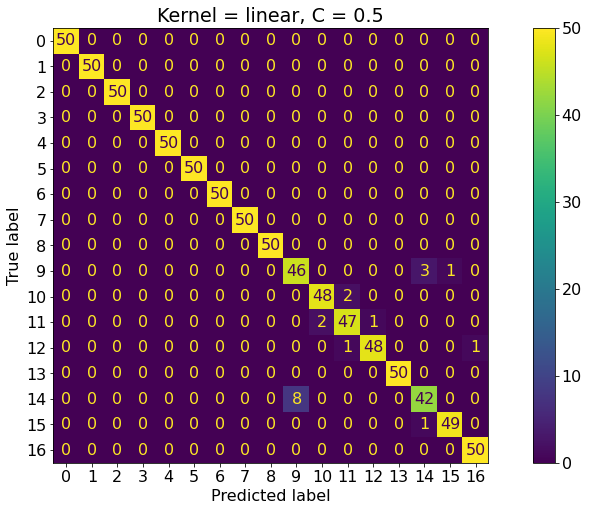

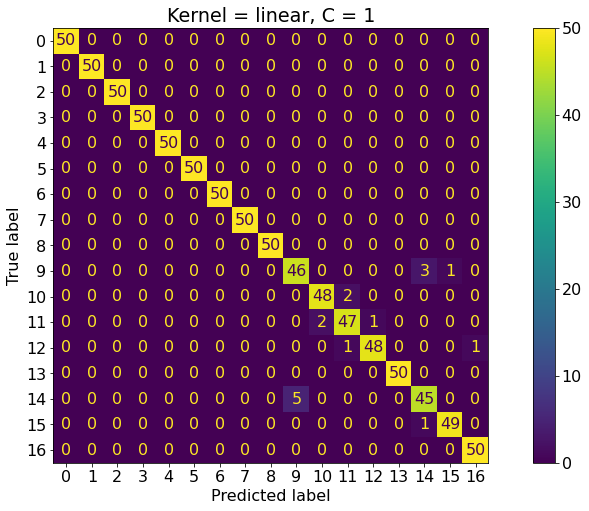

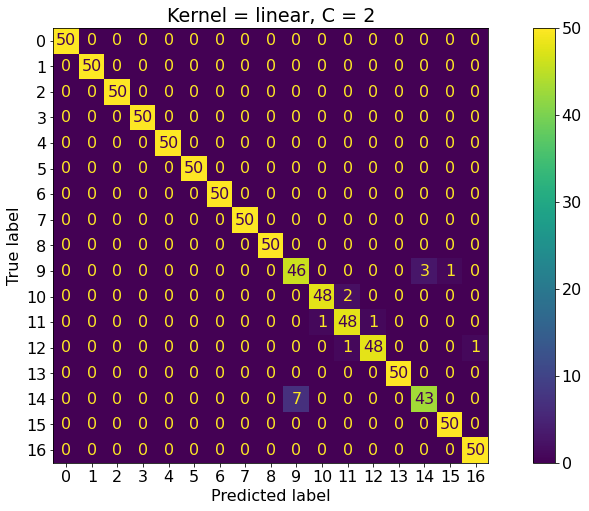

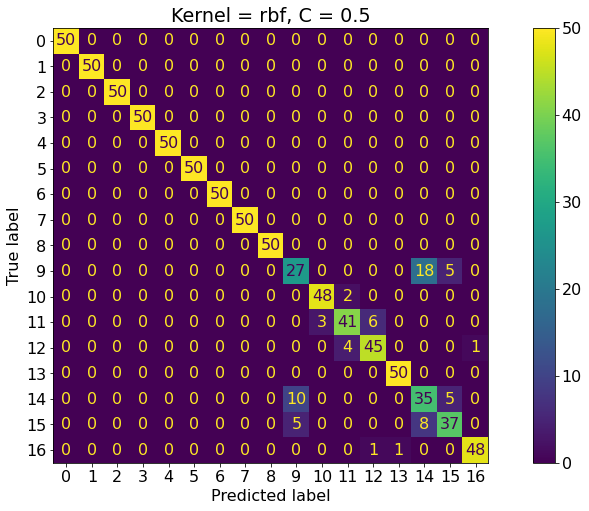

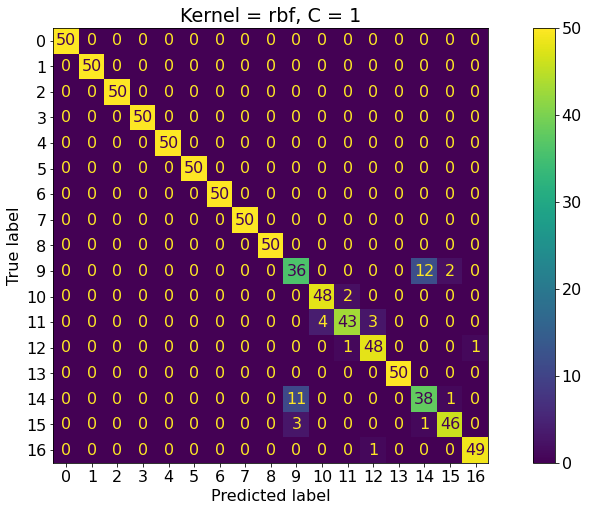

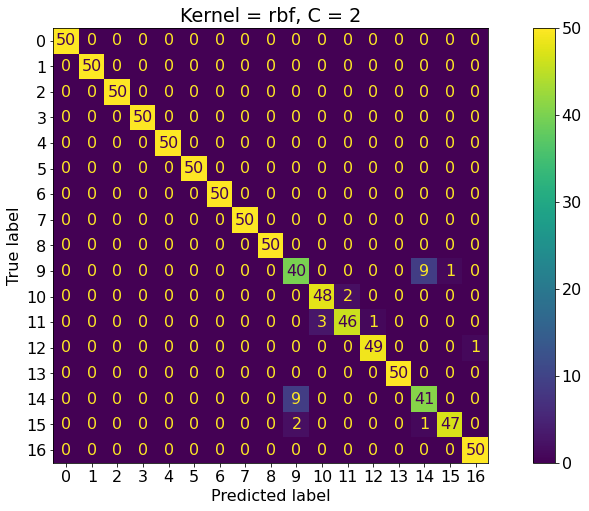

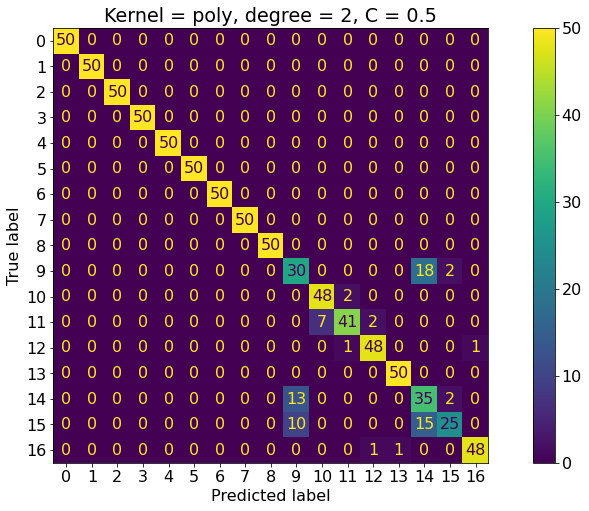

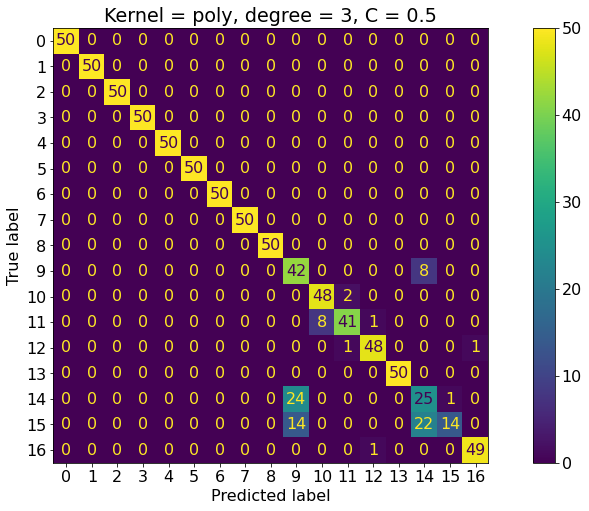

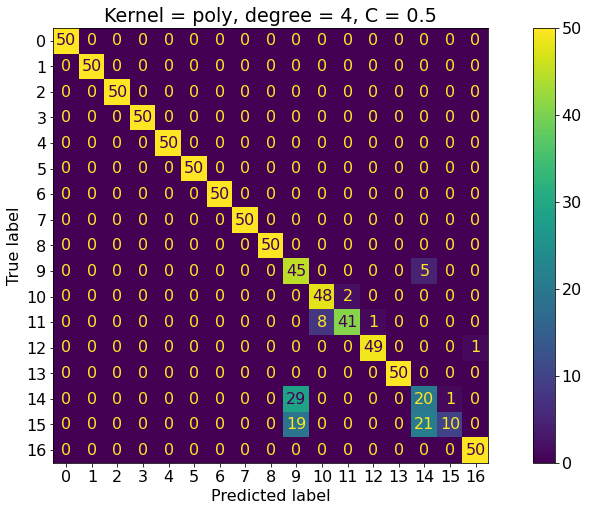

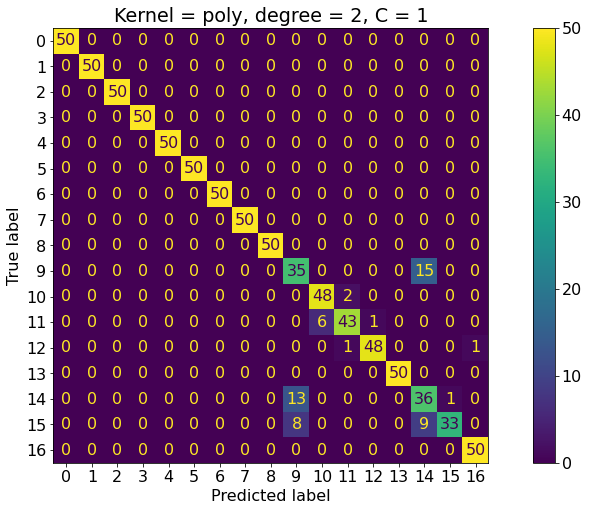

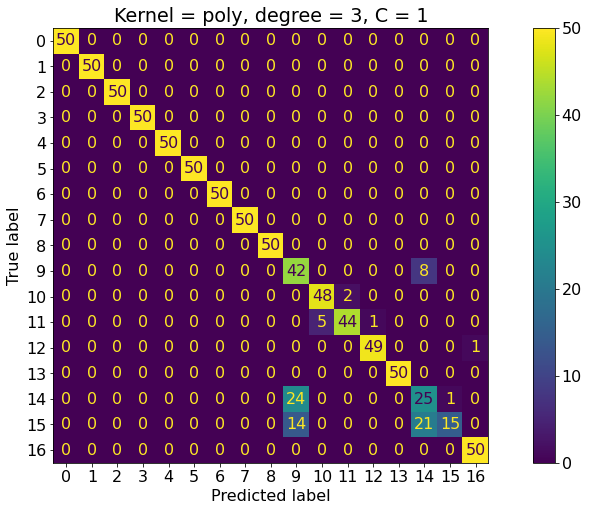

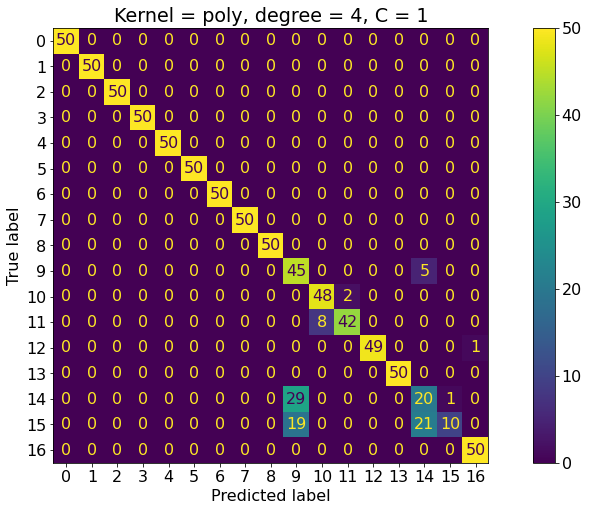

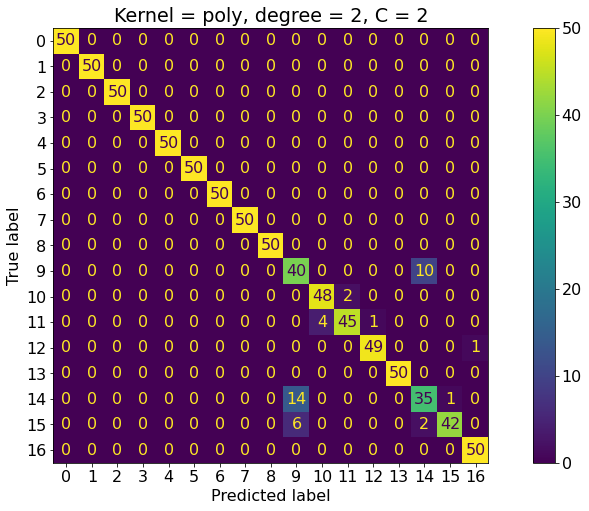

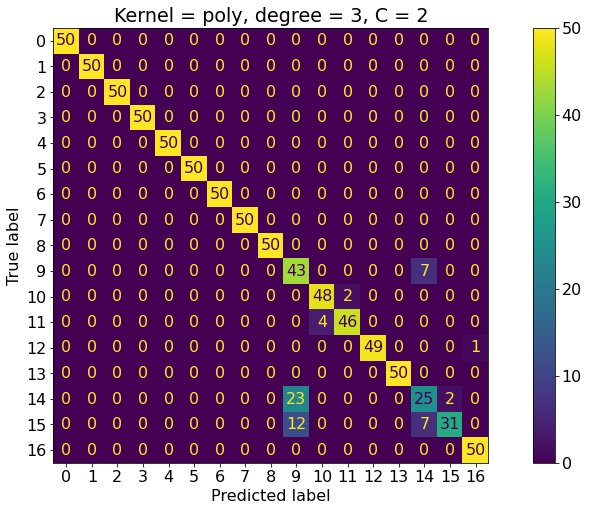

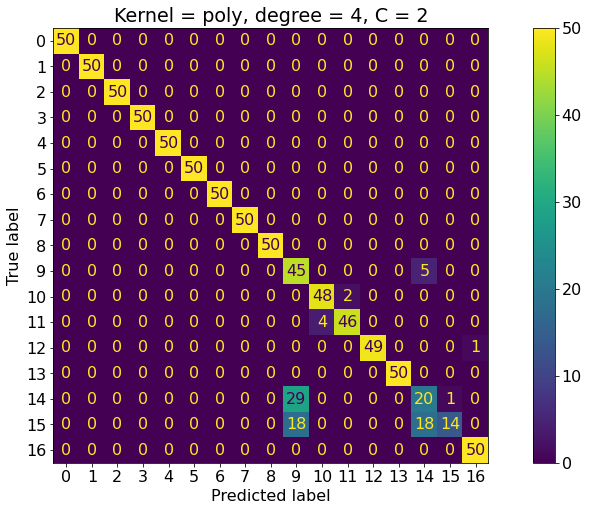

In [20]:
C_list = [0.5, 1, 2]
kernel_list = ['linear', 'rbf', 'poly']
degree_list = [2, 3, 4]

for kernel in kernel_list:
    
    print("########### Testando kernel {} ###########".format(kernel))
    
    for C in C_list:
        
        if kernel != 'poly':
            
            SVM_X2 = SVC(C = C, kernel = kernel).fit(X2, y)
            score_X2 = SVM_X2.score(X2, y)

            print('\tC = {} => score = {:.4f}'.format(C, score_X2))
            
            cm = confusion_matrix(y, SVM_X2.predict(X2))
            ConfusionMatrixDisplay(cm).plot()
            plt.title('Kernel = {}, C = {}'.format(kernel, C))
            
        else: # kernel == 'poly'
            print("\t## Testando C = {}".format(C))
            for degree in degree_list:
                
                SVM_X2 = SVC(C = C, kernel = kernel, degree = degree).fit(X2, y)
                score_X2 = SVM_X2.score(X2, y)
                
                print('\t\tDegree = {} => score = {:.4f}'.format(degree, score_X2))
                
                cm = confusion_matrix(y, SVM_X2.predict(X2))
                ConfusionMatrixDisplay(cm).plot()
                plt.title('Kernel = {}, degree = {}, C = {}'.format(kernel, degree, C))
                
    print('\n')

## Testando modelos kNN para X2

Serão testados modelos kNN variando os parâmetros número de vizinhos e as métricas para calclas as distâncias. 

Para a métrica, serão avaliados 3 tipos: euclideana (minkowski + p=2), manhattan (minkowski + p=1) e minkowski + p = 3;

Para o número de vizinhos, serão avaliados 3 valores, sendo um valor o default, um valor menor e um valor maior (3, 5 e 8).

########### Testando métrica Euclidean ###########
	Número de vizinhos = 3 => score = 0.9753
	Número de vizinhos = 5 => score = 0.9659
	Número de vizinhos = 8 => score = 0.9576


########### Testando métrica Manhattan ###########
	Número de vizinhos = 3 => score = 0.9788
	Número de vizinhos = 5 => score = 0.9671
	Número de vizinhos = 8 => score = 0.9565


########### Testando métrica Minkowski + p=3 ###########
	Número de vizinhos = 3 => score = 0.9729
	Número de vizinhos = 5 => score = 0.9682
	Número de vizinhos = 8 => score = 0.9553




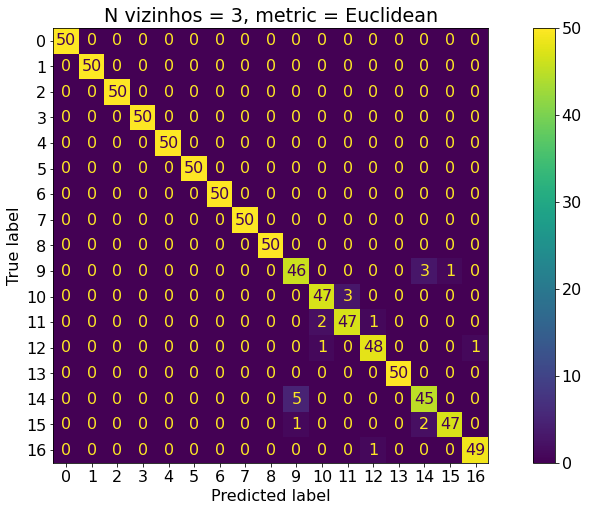

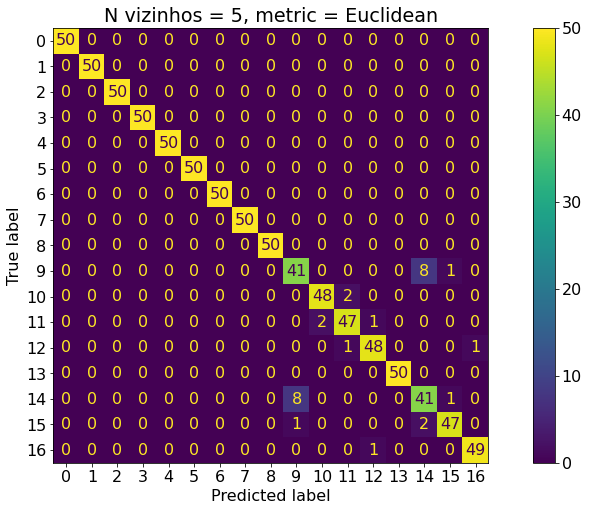

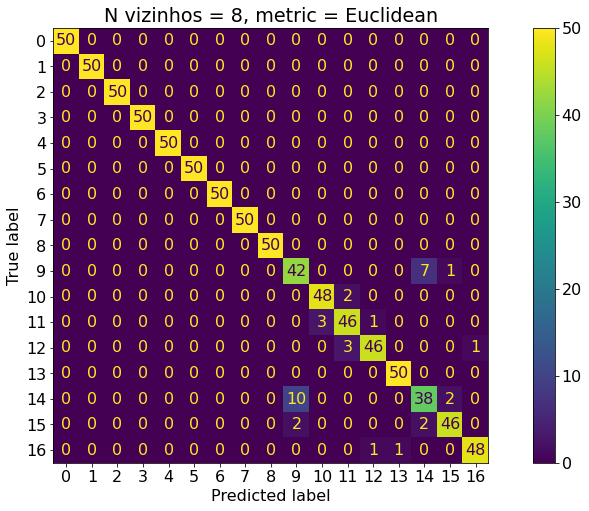

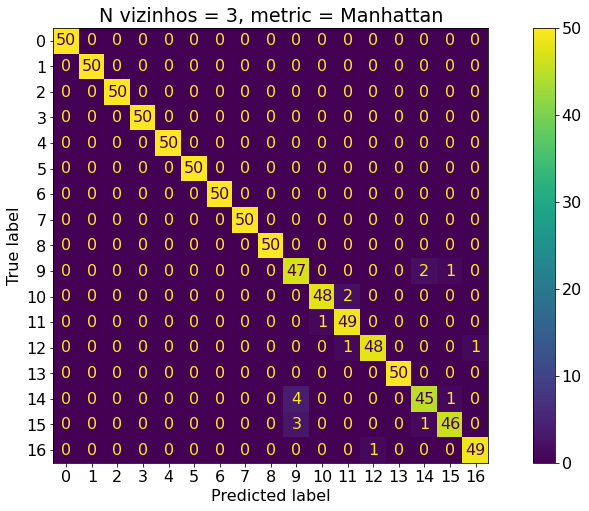

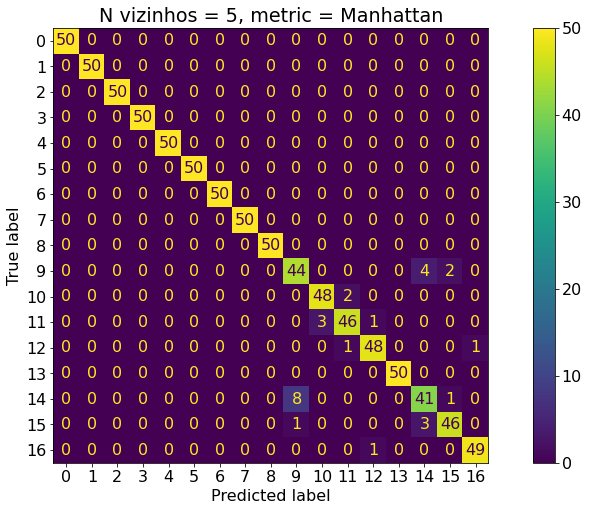

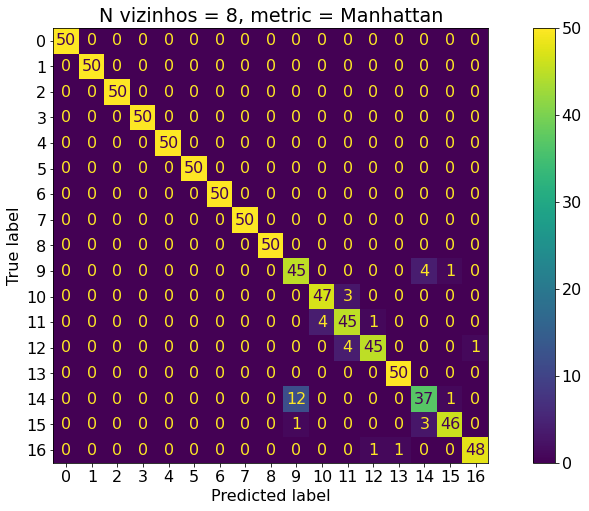

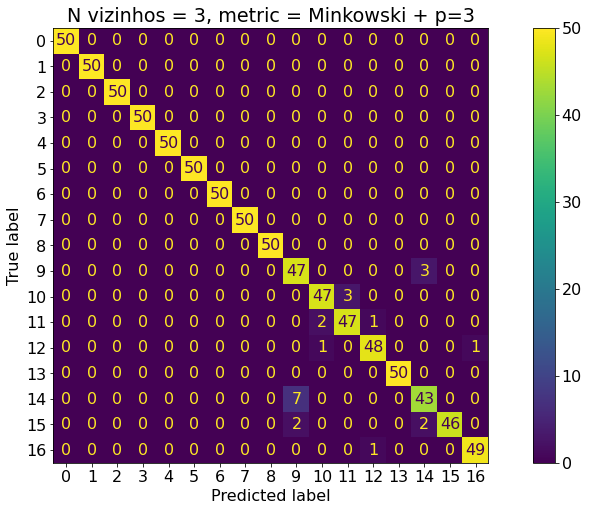

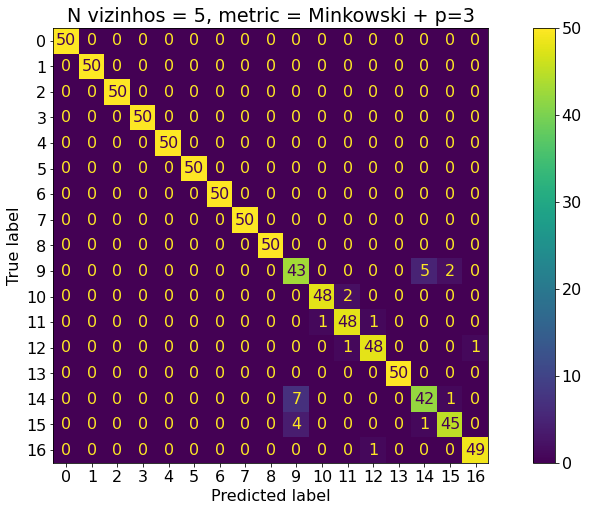

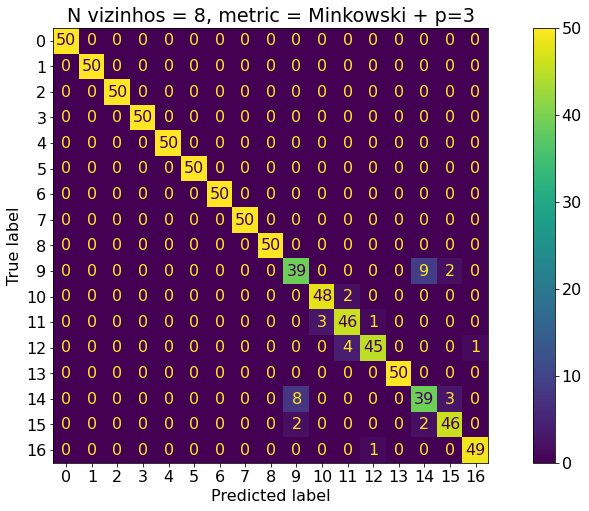

In [22]:
n_neigh_list = [3, 5, 8] 
p_list = [2, 1, 3]
metric_dic = {2: 'Euclidean', 1: 'Manhattan', 3: 'Minkowski + p=3'}

for p in p_list:
    
    print("########### Testando métrica {} ###########".format(metric_dic[p]))
    
    for n_neigh in n_neigh_list:
            
        kNN_X2 = KNeighborsClassifier(n_neighbors = n_neigh, metric = 'minkowski', p = p).fit(X2, y)
        score_X2 = kNN_X2.score(X2, y)

        print('\tNúmero de vizinhos = {} => score = {:.4f}'.format(n_neigh, score_X2))
        
        cm = confusion_matrix(y, kNN_X2.predict(X2))
        ConfusionMatrixDisplay(cm).plot()
        plt.title('N vizinhos = {}, metric = {}'.format(n_neigh, metric_dic[p]))
                
    print('\n')

## Conclusões

Primeira observação interessante dos resultados é que todos os modelos foram capazes de realizar previsões corretas para os estados 1 a 9, ou seja, o algoritmo foi capaz de identificar, de foma acurada, todos os estados associados às variações estruturais resultantes de condições de operação e ambientais.

Dos estados 10 a 17, vemos que os algoritmos começam a encontrar dificuldades, principalmente para os estados de dano (10 a 17). 

Importante ressaltar que, caso o objetivo do algoritmo fosse prever a existência de um dano qualquer ou não, os modelos ajustados estariam suficientemente bons, pois eles são capazaes de diferencias diferentes condições de operação da estrutura de danos. Porém, como o objetivo é, também, prever a extensão do dano, faz-se necessário avaliar a qualidade dos modelos para as previões dos estados 10 a 17.

Analisando os scores resultantes dos ajustes, percebe-se que ambos os modelos SVM e kNN possuem conjuntos de hyperparâmetros que ajustam melhor os dados do que o modelo linear. Porém, avaliando a matriz de confusão resultante de todos os modelos, percebe-se que mesmo os melhores modelos SVM e kNN ajustados apresentam resultados bem similares ao modelo softmax linear. Por isso, seguindo o princípio da navalha de Occam (caso dois modelos possuam desempenhos semelhantes, o mais simples deve ser escolhido), acredita-se que o moelo softmax linear tenha sido o melhor.

É interessante notar como nem sempre é necessário aumentar a complexidade do problema para ter melhores resultados. Além disso, trabalhar com modelos mais simples fornecem ganhos de produtividade e diminuem as questões acerca de overfit.